<a href="https://colab.research.google.com/github/rakibulhaque9954/sec-20-UNET_Model-Data-segmentation/blob/main/sec_20_Oxford_IIIT_Pet_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [18]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from keras.regularizers import L2, L1
from keras.initializers import RandomNormal
import tensorflow_datasets as tfds


# Dataset Download

In [19]:
dataset_name = "oxford_iiit_pet"
dataset, info = tfds.load(dataset_name, with_info=True)

In [20]:
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [21]:
train_dataset = dataset['train']
val_dataset = dataset['test']

In [ ]:
for data in train_dataset.take(1):
  im, mask = data['image'], data['segmentation_mask']
  print(im)
  print(mask)

tf.Tensor(
[[[ 3  3  3]
  [ 5  3  4]
  [ 7  5  6]
  ...
  [ 3  1  2]
  [ 3  1  2]
  [ 3  1  2]]

 [[ 4  3  1]
  [ 5  3  4]
  [ 5  3  4]
  ...
  [ 6  2  3]
  [ 7  3  4]
  [ 8  4  5]]

 [[ 4  3  1]
  [ 5  4  2]
  [ 5  3  4]
  ...
  [ 7  3  2]
  [ 8  4  3]
  [ 8  4  3]]

 ...

 [[ 6 10 11]
  [ 6  7  9]
  [ 7  8 10]
  ...
  [ 3  4  6]
  [ 3  4  6]
  [ 4  5  7]]

 [[ 8 12 13]
  [ 7  8 10]
  [ 8  9 11]
  ...
  [ 4  5  9]
  [ 4  5  7]
  [ 4  5  7]]

 [[ 8 12 13]
  [ 7  8 10]
  [ 8  9 11]
  ...
  [ 5  6 10]
  [ 5  6 10]
  [ 5  6 10]]], shape=(500, 500, 3), dtype=uint8)
tf.Tensor(
[[[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 ...

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]], shape=(500, 500, 1), dtype=uint8)


# Data Preprocessing

In [22]:
BATCH_SIZE  = 16
LR = 1e-3
EPOCH = 100
INPUT_DIM = 224
NUM_FILTERS = 128
input_dim = 224
NUM_CLASSES = 3

In [23]:
def preprocess_data(data):
      image = tf.image.resize(data['image'], (input_dim, input_dim))
      mask = tf.image.resize(data['segmentation_mask'], (input_dim, input_dim))
      # Convert mask to integer type
      mask = tf.cast(mask, dtype=tf.int32)

      # Convert mask to one-hot encoding
      mask = tf.one_hot(tf.squeeze(mask), depth=NUM_CLASSES)

      # Normalize image to [0, 1]
      image = tf.image.convert_image_dtype(image, tf.float32)

      return image, mask

In [24]:
train_dataset = (train_dataset
                 .map(preprocess_data)
                 .prefetch(tf.data.AUTOTUNE))

In [25]:
val_dataset = (val_dataset
                 .map(preprocess_data)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

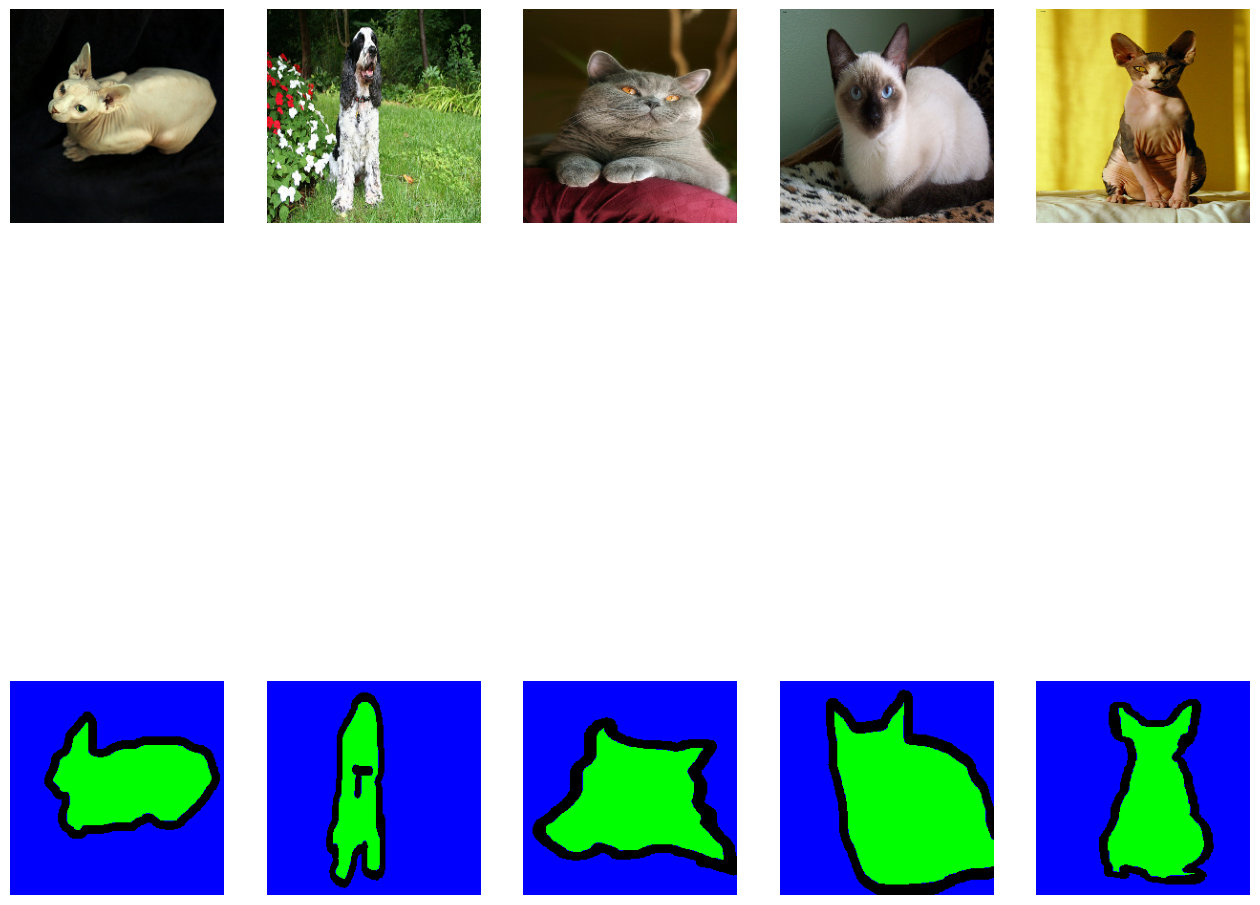

In [26]:
import matplotlib.pyplot as plt
import numpy as np
f, ax = plt.subplots(2, 5, figsize = (16, 16))
for idx,(img, mask) in enumerate(train_dataset.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis('off')
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis('off')

In [27]:
train_dataset = train_dataset.batch(BATCH_SIZE)

# Modeling UNET model(base)

In [29]:
def get_base_model():

    base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape = (INPUT_DIM, INPUT_DIM, 3), include_top = False)

    # freeze base model
    base_model.trainable = False


    conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out=[base_model.get_layer(layer_name).output for layer_name in ["conv1_relu","conv2_block3_out","conv3_block4_out","conv4_block6_out","conv5_block3_out"]]
    # getting layer outputs and passing each output in the form of the size as seen in the model
    return Model(
        inputs=[base_model.inputs],outputs=[conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out]
    )
get_base_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [30]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self,NUM_FILTERS):
        super(Upsample,self).__init__()
        self.conv_t_1=tf.keras.layers.Conv2DTranspose(NUM_FILTERS,1,strides=2,activation='relu')
        self.norm_1=BatchNormalization()
    def call(self,x):
        x=self.norm_1(self.conv_t_1(x))
        return x

In [31]:
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self,NUM_FILTERS):
        super(ConvLayers,self).__init__()
        self.conv_1=Conv2D(NUM_FILTERS*2,3,padding='same',activation='relu')
        self.norm_1=BatchNormalization()

        self.conv_2=Conv2D(NUM_FILTERS*4,3,padding='same',activation='relu')
        self.norm_2=BatchNormalization()
    def call(self,x):
        x=self.norm_1(self.conv_1(x))
        x=self.norm_2(self.conv_2(x))
        return x

In [32]:
from keras.layers import UpSampling2D

inputs=tf.keras.Input(shape=(INPUT_DIM,INPUT_DIM,3))
x=Rescaling(1/255.)(inputs)
x_112,x_56,x_28,x_14,x_7=get_base_model()(x)

x=Upsample(NUM_FILTERS)(x_7)
x=tf.concat([x,x_14],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_28],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_56],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_112],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)

x = UpSampling2D(size=(2, 2))(x)

output = Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax')(x)
model=tf.keras.Model(inputs=inputs,outputs=output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 model_5 (Functional)        [(None, 112, 112, 64),       2358771   ['rescaling_1[0][0]']         
                              (None, 56, 56, 256),        2                                       
                              (None, 28, 28, 512),                                                
                              (None, 14, 14, 1024),                                         

# Checkpoint

In [33]:
checkpoint_filepath='/content/drive/MyDrive/Colab Notebooks/Unet_Model'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

# Model compilation and fitting


In [34]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = Adam(learning_rate = LR),
    metrics='accuracy',
    run_eagerly = True,
)

In [68]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    verbose=1,
    shuffle=True,
    epochs=10,
    callbacks = [callback]
    )

Epoch 1/10
230/230 [==============================] - 111s 483ms/step - loss: 0.3118 - accuracy: 0.7847 - val_loss: 17.6066 - val_accuracy: 0.4941
Epoch 2/10
230/230 [==============================] - 110s 479ms/step - loss: 0.3100 - accuracy: 0.7856 - val_loss: 47.2152 - val_accuracy: 0.4369
Epoch 3/10
230/230 [==============================] - 110s 478ms/step - loss: 0.3101 - accuracy: 0.7853 - val_loss: 164.8333 - val_accuracy: 0.6483
Epoch 4/10
230/230 [==============================] - 110s 478ms/step - loss: 0.3072 - accuracy: 0.7860 - val_loss: 80.7082 - val_accuracy: 0.4651
Epoch 5/10
230/230 [==============================] - 110s 478ms/step - loss: 0.3052 - accuracy: 0.7862 - val_loss: 284.5088 - val_accuracy: 0.5135
Epoch 6/10
230/230 [==============================] - 110s 480ms/step - loss: 0.3043 - accuracy: 0.7862 - val_loss: 12.6923 - val_accuracy: 0.6214
Epoch 7/10
230/230 [==============================] - 110s 478ms/step - loss: 0.3005 - accuracy: 0.7875 - val_loss: 

In [69]:
test_image = '/Abyssinian_1.jpg'

In [70]:
X=[]
X.append(img_to_array(load_img(test_image,target_size=(224,224))))
image_output=tf.argmax(model.predict(tf.constant(X)),axis=-1)[0]
image_output=tf.expand_dims(image_output,axis = -1) # becuase channels are -1
image_output.shape

1/1 [==============================] - 0s 139ms/step


TensorShape([224, 224, 1])

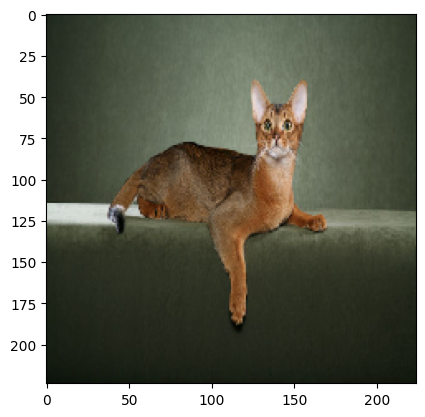

In [71]:
image=tf.keras.preprocessing.image.load_img(test_image,color_mode='rgb',target_size=(224,224))
plt.imshow(image)
plt.show()

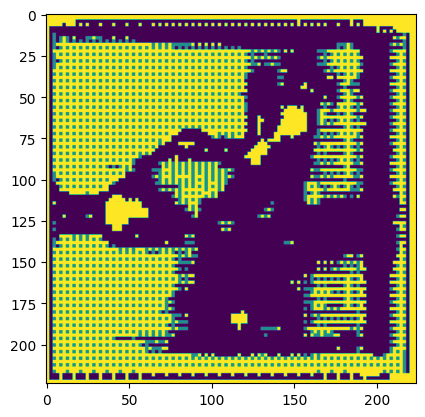

In [72]:
plt.imshow(image_output)
plt.show()